# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python.

## Setup

We first import the LensKit components we need:

In [1]:
from lenskit import batch, topn
from lenskit import crossfold as xf
from lenskit.algorithms import als, item_knn as knn
from lenskit.metrics import topn as tnmetrics

And Pandas is very useful:

In [2]:
import pandas as pd

In [3]:
%matplotlib inline

## Loading Data

We're going to use the ML-100K data set:

In [4]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t',
                      names=['user', 'item', 'rating', 'timestamp'])
ratings.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Defining Algorithms

Let's set up two algorithms:

In [5]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

We will first define a function to generate recommendations from one algorithm over a single partition of the data set.  It will take an algorithm, a train set, and a test set, and return the recommendations:

In [6]:
def eval(aname, algo, train, test):
    model = algo.train(train)
    users = test.user.unique()
    # the recommend function can merge rating values
    recs = batch.recommend(algo, model, users, 100,
            topn.UnratedCandidates(train), test)
    # add the algorithm
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [7]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

With the results in place, we can concatenate them into a single data frame:

In [8]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,rating,Algorithm
0,1449,4.715001,3,1,0.0,ItemItem
1,1203,4.477979,3,2,0.0,ItemItem
2,1191,4.360026,3,3,0.0,ItemItem
3,119,4.308028,3,4,0.0,ItemItem
4,1269,4.208256,3,5,0.0,ItemItem


In [9]:
test_data = pd.concat(test_data, ignore_index=True)

nDCG is a per-user metric. Let's compute it for each user.

However, there is a little nuance: the recommendation list does not contain the information needed to normalize the DCG. Specifically, the nDCG depends on _all_ the user's test items.

So we need to do three things:

1. Compute DCG of the recommendation lists.
2. Compute ideal DCGs for each test user
3. Combine and compute normalized versions

We do assume here that each user only appears once per algorithm. Since our crossfold method partitions users, this is fine.

In [10]:
user_dcg = all_recs.groupby(['Algorithm', 'user']).rating.apply(tnmetrics.dcg)
user_dcg = user_dcg.reset_index(name='DCG')
user_dcg.head()

,Algorithm,user,DCG
0,ALS,1,13.987408
1,ALS,2,6.066743
2,ALS,3,0.000000
3,ALS,4,1.204120
4,ALS,5,8.263124


In [11]:
ideal_dcg = tnmetrics.compute_ideal_dcgs(test)
ideal_dcg.head()

,user,ideal_dcg
0,16,43.192451
1,21,38.017477
2,26,26.095144
3,33,14.815749
4,34,8.130930


In [12]:
user_ndcg = pd.merge(user_dcg, ideal_dcg)
user_ndcg['nDCG'] = user_ndcg.DCG / user_ndcg.ideal_dcg
user_ndcg.head()

,Algorithm,user,DCG,ideal_dcg,nDCG
0,ALS,16,13.216122,43.192451,0.305982
1,ItemItem,16,9.425342,43.192451,0.218217
2,ALS,21,3.474886,38.017477,0.091402
3,ItemItem,21,2.550530,38.017477,0.067088
4,ALS,26,3.256464,26.095144,0.124792


Now we have nDCG values!

In [13]:
user_ndcg.groupby('Algorithm').nDCG.mean()

Algorithm
ALS         0.133523
ItemItem    0.100200
Name: nDCG, dtype: float64

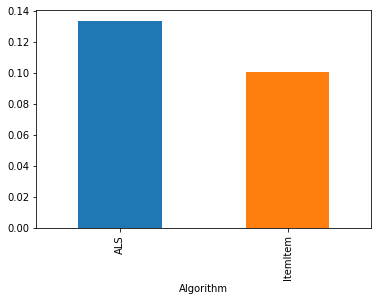

In [14]:
user_ndcg.groupby('Algorithm').nDCG.mean().plot.bar()